# Face Recognition #4

- We are using: DB1-Youtube 
- We are performing one different embedding for each person from the first video
- We are then planning are crossing test on all the other person's videos.


In [0]:
import sys
import os
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/PRIM'  # your new root path

sys.path.append(os.path.join(root_path, 'notebooks')) # for importing from utils.py

!pip install face_recognition

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
     |████████████████████████████████| 100.2MB 73kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=dd382f18d560ed3e0828b6afa0389253b2727c7c5d7aa6f9d7cf9fc5a49a1c7a
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [0]:
import argparse
import pickle
import cv2
from imutils import paths
import face_recognition
import argparse
import pickle
import cv2
import os
import dlib
import matplotlib.pyplot as plt
import time
import pdb
import numpy as np

print(dlib.DLIB_USE_CUDA)

True


In [0]:
def createEncodings(dataset_folder, name, detection='cnn'):

    # grab the paths to the input images in our dataset
    print("[INFO] quantifying faces...")
    imagePathsList = list(paths.list_images(dataset_folder))
    '''
    We're going to take only a limit number of images to create the encodings.
    We'll take a random sample over all the images of a person and in particular
    '''
    num = 20
    if len(imagePathsList )<= 0:
      return

    imagePaths = random.choices(imagePathsList, k = num )

    # initialize the list of known encodings and known names
    knownEncodings = []
    knownNames = []
    # loop over the image paths
    for (i, imagePath) in enumerate(imagePaths):
        # extract the person name from the image path
        #print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))
        name = imagePath.split(os.path.sep)[-3]

        # load the input image and convert it from RGB (OpenCV ordering)
        # to dlib ordering (RGB)
        image = cv2.imread(imagePath)
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # detect the (x, y)-coordinates of the bounding boxes
        # corresponding to each face in the input image
        boxes = face_recognition.face_locations(rgb,model=detection)

        # compute the facial embedding for the face
        encodings = face_recognition.face_encodings(rgb, boxes)

        # loop over the encodings
        for encoding in encodings:
            # add each encoding + name to our set of known names and
            # encodings
            knownEncodings.append(encoding)
            knownNames.append(name)
    #pdb.set_trace()
    # dump the facial encodings + names to disk
    print("[INFO] serializing encodings..." + name)
    data = {"encodings": knownEncodings, "names": knownNames}
    name = root_path + "/encodings/" + name + '.pkl'
    #print(name)
    f = open(name, "wb")
    f.write(pickle.dumps(data))
    f.close()

In [0]:
def faceRecognition(image, encodings, detection='cnn', show=False):
    start = time.time()
    # the image is already converted in an rgb format
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # format used by openCV
    data = encodings

    # detect the (x, y)-coordinates of the bounding boxes corresponding
    # to each face in the input image, then compute the facial embeddings
    # for each face
    boxes = face_recognition.face_locations(rgb,model=detection)
    encodings = face_recognition.face_encodings(rgb, boxes)

    # initialize the list of names for each face detected
    names = []

    # loop over the facial embeddings
    for encoding in encodings:
        # attempt to match each face in the input image to our known
        # encodings
        matches = face_recognition.compare_faces(data["encodings"],
            encoding)
        name = "unknown"

        # check to see if we have found a match
        if True in matches:
          # Or instead, use the known face with the smallest distance to the new face
          face_distances = face_recognition.face_distance(data["encodings"], encoding)
          best_match_index = np.argmin(face_distances)
          if matches[best_match_index]:
              name = data["names"][best_match_index]

        # update the list of names
        try:
            name = name.split('/')[2]
        except:
            name = name
        names.append(name)

    # loop over the recognized faces
    for ((top, right, bottom, left), name) in zip(boxes, names):
        # draw the predicted face name on the image
        cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
        y = top - 15 if top - 15 > 15 else top + 15
        cv2.putText(image, name, (left, y), cv2.FONT_HERSHEY_SIMPLEX,
            0.75, (0, 255, 0), 2)
    
    
    stop = time.time()
    #print('Time needed:', stop-start, 'sec')
    # show the output image
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if(show== True):
        print(names)
        plt.imshow(rgb)
        plt.show()
    return names

def imageRead(path, show=True):
    # BGR FORMAT #
    image = cv2.imread(path)
    
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if(show== True):
        plt.imshow(rgb)
        plt.show()
    return image
    
def encodingsRead(path):
    ## PAY ATTENTION:: You need to create the encoding for you dataset using encode_face.py
    data = pickle.loads(open(path, "rb").read())
    return data
    

In [0]:
def faceRecOnFolder(dataset_folder, encodings, correct_person, detection='cnn', min_threshold = 0.85, 
                    max_threshold=0.10,
                    show=False):
    imagePaths = list(paths.list_images(dataset_folder))

    analysed_frames = 0
    correct_frames = 0
    negative_frames = 0
    neutrum_frames = 0
    total_frames = len(imagePaths)
    start = time.time()
    
    min_frames = total_frames * 80 / 100
    min_threshold = min_threshold
    # grab the paths to the input images in our dataset
    print("[INFO] Recognizing faces...")
    print("[INFO] elements:", total_frames)

    # loop over the image paths
    for (i, imagePath) in enumerate(imagePaths):
        # extract the person name from the image path
        #print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))
        image = imageRead(imagePath, show=False)
        person_rec = faceRecognition(image, encodings, detection='cnn', show=show)
        analysed_frames += 1
        
        if(len(person_rec) >= 1):
            person = person_rec[0]
            if(person == correct_person):
                correct_frames += 1
            else:
                if(person == 'unknown'):
                    neutrum_frames += 1
                else:
                    negative_frames += 1
        else:
            neutrum_frames += 1
        
            
        if( analysed_frames > min_frames and correct_frames/analysed_frames > min_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            end = time.time()
            print('Time:', end-start)
            return True, correct_rate, neutrum_rate, negative_rate
        
        if( analysed_frames > min_frames and correct_frames/analysed_frames < max_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            end = time.time()
            print('Time:', end-start)
            return False, correct_rate, neutrum_rate, negative_rate
        
    #for ends
    correct_rate = correct_frames/total_frames
    neutrum_rate = neutrum_frames/total_frames
    negative_rate = negative_frames/total_frames
    end = time.time()
    print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/total_frames)
    print('Not detected:', neutrum_frames/total_frames, ". Wrong recognition:", negative_frames/total_frames)
    print('Time:', end-start)
    if(correct_rate > min_threshold - 0.05):
        return True, correct_rate, neutrum_rate, negative_rate
    else:
        return False, correct_rate, neutrum_rate, negative_rate

Let's start the new test.

In [0]:
encodings_folder = root_path + "/encodings/"
test_path = root_path + "/frame_images_mattia/"

In [0]:
 logfile = open(root_path + "/logs/log_" + "mammeta" + ".txt", "w")
 
 logfile.write("tua mamma è troia")
 
 logfile.close()

In [0]:

###########       FARE LE STATISTICHEEEEEEEE
##### USARE SOLO IL PRIMO FOLDER
##### Fermarsi dopo tot immagini (stop condition)

def performCrossedTest(min_v=0, max_v=1000, threshold=0.85, log=False):
    print("-------------------------")
    print("TEST STARTED")
    print("-------------------------")
    start = time.time()
    #pdb.set_trace()
    count = 0
    enc_list = os.listdir(encodings_folder)
    test_dir = os.listdir(test_path)
    
    #filev = open("./valid.txt", "r")
    #valid_persons = filev.readlines()
    #filev.close()

    for encoding in enc_list:
        count = count + 1
        if(count < min_v):
            continue
        if(count > max_v):
            break
        n_test = 0
        n_correct = 0
        enc_name = encoding[0:len(encoding)-4]#removing '.pkl' from name
        encoding_path = encodings_folder + encoding

        print('[ENC] Using encoding:', enc_name)

        curr_encoding = encodingsRead(encoding_path)
  
        if( log == True ):
            logfile = open(root_path + "/logs/log_" + enc_name + ".txt", "w")
        
        
        for person in test_dir:
            
            if ( enc_name == person ):
              continue


            #person = person[0:len(person)-1]
            test_folder = test_path + person
            print('Testing on test folder:', person)
            folder_list = os.listdir(test_folder)

            #person = person[0:len(person)]
            #test_folder = test_path + person

            # test the encodings of testset
            train_flag = 0
            just_first = 0
            for n_folder in folder_list:
                if( enc_name == person ):
                    if( train_flag == 0):
                        train_flag = 1
                        continue
                
                if( just_first == 1):
                    break
                    
                just_first +=1
                n_test += 1
                folder = test_folder + "/" + n_folder
              
                #imagePaths = list(os.listdir(test_path + person + "/"))

                print(folder)
                v, a, b, c = faceRecOnFolder(folder, curr_encoding, person, min_threshold=threshold, show=False)
                if(log== True):
                    line = person + " " + n_folder + " " + str(v) + " " + str(a) + " " + str(b) + " " + str(c) + "\n"
                    logfile.write(line)
                    #print(line)
                if( v == True):
                    n_correct += 1

        if(log == True):
            logfile.close()
        '''
        except:
          print("[AN ERROR OCCURRED]")
          if(log == True):
            logfile.close()
        '''
    end = time.time()
    print("-------------------------")
    print("TEST ENDED")
    print("-------------------------")
    print('This test last:', end-start)
    return

### Only 30 people, one folder for each and 80% of each folder images

In [0]:
performCrossedTest(min_v=0, max_v=100, log=True)

-------------------------
TEST STARTED
-------------------------
[ENC] Using encoding: Jan_Ullrich
Testing on test folder: Jacky_Cheung
gdrive/My Drive/Colab Notebooks/PRIM/frame_images_mattia/Jacky_Cheung/0
[INFO] Recognizing faces...
[INFO] elements: 84
Jacky_Cheung Recognized after 68 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 9.771179914474487
Testing on test folder: Jacqueline_Gold
gdrive/My Drive/Colab Notebooks/PRIM/frame_images_mattia/Jacqueline_Gold/2
[INFO] Recognizing faces...
[INFO] elements: 81
Jacqueline_Gold Recognized after 65 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 26.674406051635742
Testing on test folder: Jack_Welch
gdrive/My Drive/Colab Notebooks/PRIM/frame_images_mattia/Jack_Welch/3
[INFO] Recognizing faces...
[INFO] elements: 197
Jack_Welch Recognized after 158 with accuracy: 0.0
Not detected: 0.9936708860759493 . Wrong recognition: 0.006329113924050633
Time: 61.235753774642944
Testing on test folder: Jack_Osbou

We specifically analyse now some results with very high percentage of wrong results.

### Statistics

In [0]:
log_folder = root_path+"/logs/"

files = os.listdir(log_folder)


values = [0.0, 0.45, 0.50, 0.55, 0.60, 0.65, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99, 0.9999]
confirmed_rate = np.zeros(len(values))
i = 0

for thr in values:
    total_files = 0
    recognized = 0
    notdetected = 0
    wrong = 0
    wrong_confirmed = 0
    wrong_confirmed2 = 0
    wrong_confirmed3 = 0
    wrong_confirmed4 = 0

    ####
    one_wrong_rec = 0
    persons = 0
    for f in files:
        if( f.startswith('log') == True):
            filev = open(log_folder + f, "r")
            vector = f.split('_')
            correct_person = vector[1] + "_" + vector[2]
            lines = filev.readlines()
            persons += 1
            for line in lines: 
                #we don't want to make statistics on the same person
                if(line.split(' ')[0] == correct_person):
                    continue

                total_files += 1

                rec_flag = line.split(' ')[2]
                rec_percentage = float(line.split(' ')[3])
                notdec_percentage = float(line.split(' ')[4])
                notrec_percentage = float(line.split(' ')[5])

                recognized = recognized + rec_percentage
                notdetected = notdetected + notdec_percentage
                wrong = wrong + notrec_percentage

                if(notrec_percentage > thr):
                    wrong_confirmed = wrong_confirmed + 1

    confirmed_rate[i] = wrong_confirmed / total_files
    wrong_confirmed = 0
    i = i +1

## equal for each iteration
positive = recognized / total_files 
undetected = notdetected / total_files
negative = wrong / total_files

wrong_rec_on_persons = one_wrong_rec / (persons-1)

Percentage of overall images that were correctly not recognized: 0.9332888706503042
Percentage of overall images that were wrongly not recognized: 0.06671112934969353


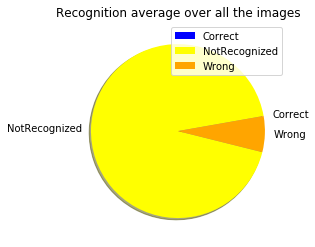

In [0]:
## WRONG ONES WHERE ASSIGNED TO THE PERSON EVEN HE WASN'T

labels = ['Correct', 'NotRecognized', 'Wrong']
colors = ['Blue', 'Yellow', 'Orange']
sizes1 = [positive, undetected, negative]
print('Percentage of overall images that were correctly not recognized:', undetected)
print('Percentage of overall images that were wrongly not recognized:', negative)

plt.pie(sizes1, labels=labels, shadow=True, startangle=10, colors=colors)
plt.title('Recognition average over all the images')
plt.legend()
plt.show()


All the performed tests (excluding that one on the same person) should result false. Let's see what would happen using the metrics we used in #3

Percentage of people wrongly confirmed using threshold 0.65 is: 0.04073413877335446


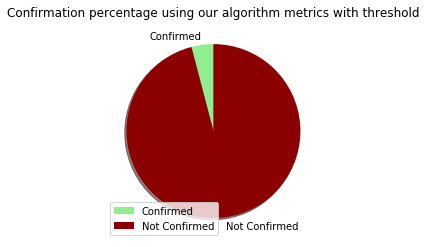

Percentage of people wrongly confirmed using threshold 0.75 is: 0.03307585660526837


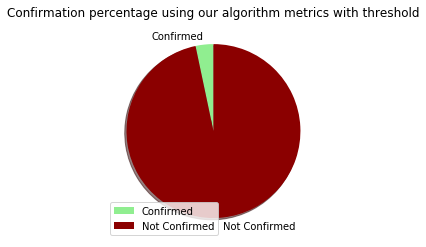

Percentage of people wrongly confirmed using threshold 0.8 is: 0.02832244008714597


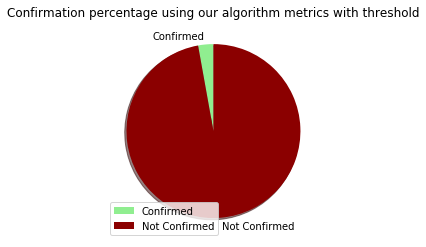

Percentage of people wrongly confirmed using threshold 0.85 is: 0.02482339737241698


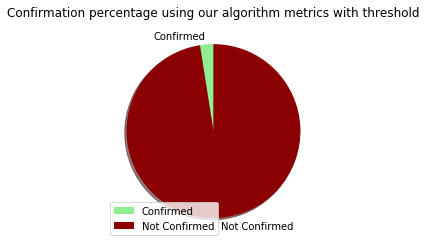

Percentage of people wrongly confirmed using threshold 0.9 is: 0.019079685746352413


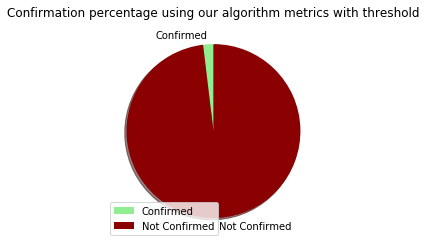

Percentage of people wrongly confirmed using threshold 0.95 is: 0.013996170858915956


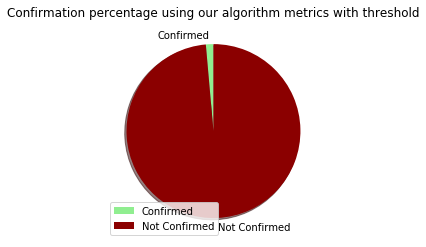

Percentage of people wrongly confirmed using threshold 0.99 is: 0.010563147818049779


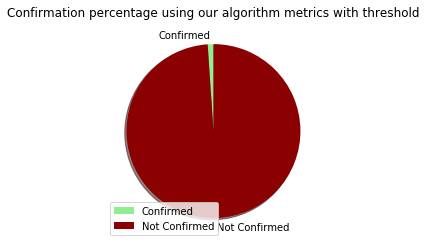

Percentage of people wrongly confirmed using threshold 0.9999 is: 0.010431108470324156


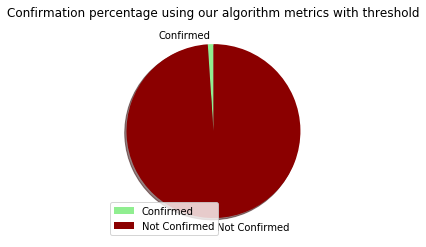

In [0]:
fpr = np.zeros(4)
i =0
for cfr in confirmed_rate:
    if( i < 5 ):
        i = i +1
        continue
    labels = ['Confirmed', 'Not Confirmed']
    colors = ['Lightgreen', 'DarkRed']
    sizes1 = [cfr, (1 - cfr)]
    print('Percentage of people wrongly confirmed using threshold', values[i], 'is:', cfr)

    plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
    plt.title('Confirmation percentage using our algorithm metrics with threshold')
    plt.legend()
    plt.show()
    i = i +1

An idea to fix it could be asking the 1.0 accuracy to predict a video as True. This almost always happened in the previous test, when we compared the same subjects. And it was suitable also with a greedy stopping condition.

Indeed we can see that even if there are some mispredictions here, due to embedding faces that have no clear characteristics, it never happens to assign the whole (1.0) of the frame to the wrong person.

So we computed the FAR. Let's compute now the TAR (True Accepted Rate) in every threshold case.

In [0]:

TAR_path = root_path + "/#3_logs/"

import os
files = os.listdir(TAR_path)
confirmed_rateT = np.zeros(len(values))
i=0

for thr in values:
    total_files = 0
    recognized = 0
    notdetected = 0
    wrong = 0
    confirmed = 0
    total_files = 0
    
    for f in files:
        if( f.startswith('log') == True):
            filev = open(TAR_path + f, "r")
            lines = filev.readlines()
            for line in lines:
                total_files += 1

                rec_flag = line.split(' ')[2]
                rec_percentage = float(line.split(' ')[3])
                notdec_percentage = float(line.split(' ')[4])
                notrec_percentage = float(line.split(' ')[5])

                recognized = recognized + rec_percentage
                notdetected = notdetected + notdec_percentage
                wrong = wrong + notrec_percentage
                if(rec_percentage > thr):
                    confirmed = confirmed + 1

    confirmed_rateT[i] = confirmed / total_files
    
    positive = recognized / total_files 
    undetected = notdetected / total_files
    negative = wrong / total_files
    
    i = i + 1



Percentage of TAR using threshold 0.65 is 0.869281045751634


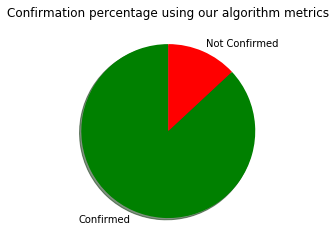

Percentage of TAR using threshold 0.75 is 0.8562091503267973


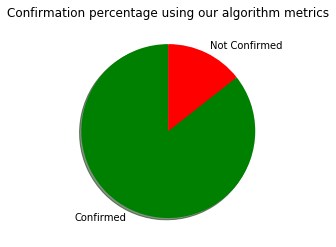

Percentage of TAR using threshold 0.8 is 0.8104575163398693


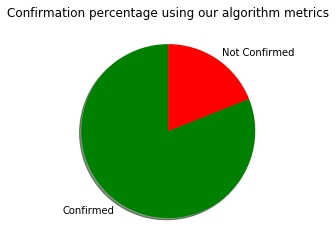

Percentage of TAR using threshold 0.85 is 0.7810457516339869


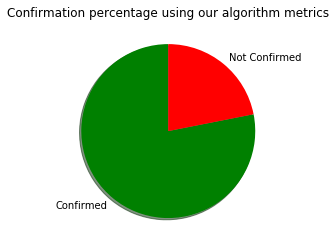

Percentage of TAR using threshold 0.9 is 0.7712418300653595


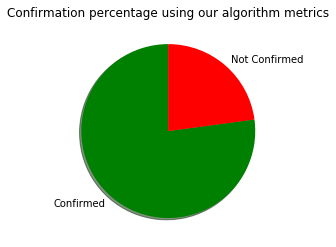

Percentage of TAR using threshold 0.95 is 0.7450980392156863


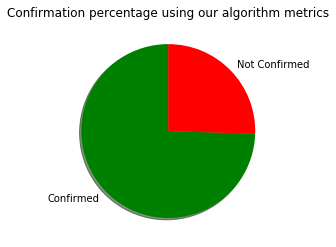

Percentage of TAR using threshold 0.99 is 0.7156862745098039


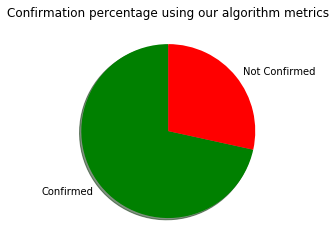

Percentage of TAR using threshold 0.9999 is 0.7091503267973857


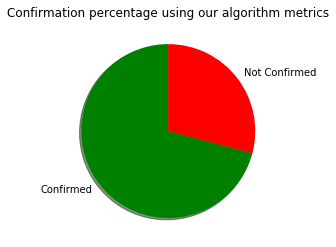

In [0]:
i = 0
for cfr in confirmed_rateT:
    if( i < 5 ):
        i = i +1
        continue
    labels = ['Confirmed', 'Not Confirmed']
    colors = ['Green', 'Red']
    sizes1 = [cfr, (1 - cfr)]
    print('Percentage of TAR using threshold', values[i], 'is', cfr)
    i = i+ 1

    plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
    plt.title('Confirmation percentage using our algorithm metrics')
    plt.show()

Obviously the TAR decreases when we increase the threshold.

It's time to build a basic ROC curve when we show just the threshold that minimize the FAR.

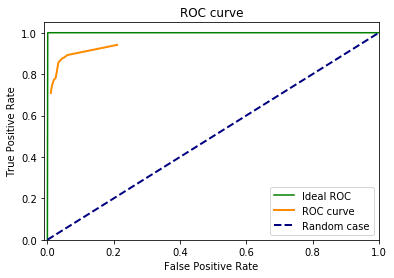

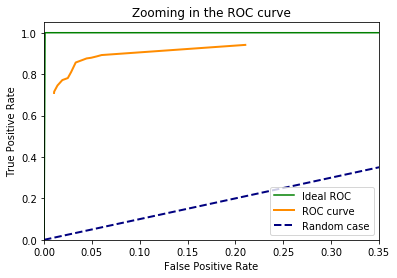

In [0]:
from sklearn.metrics import roc_curve, auc
fpr = confirmed_rate
tpr = confirmed_rateT
exampleX = [0.0, 0.001, 0.2, 0.8, 1.0]
exampleY = [0.0, 1.0, 1.0, 1.0, 1.0]

plt.figure()
lw = 2
plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

plt.figure()
lw = 2
plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
plt.xlim([0.0, 0.35])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zooming in the ROC curve')
plt.legend(loc="lower right")
plt.show()

